In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

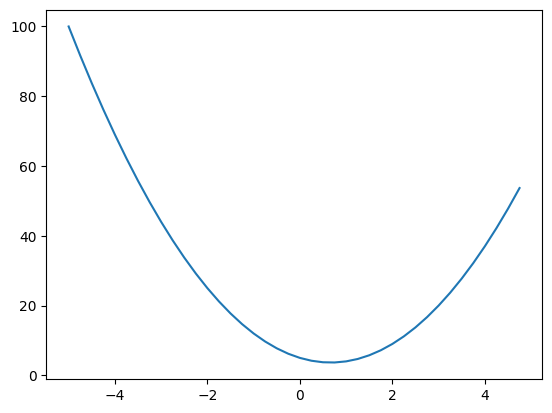

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = .00000000001
x = -3
(f(x + h) - f(x)) / h

-21.999824184604222

In [6]:
# lets get more complex
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [7]:
h = .0001

# inputs
a = 2
b = -3
c = 10

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4
d2 3.999699999999999
slope -3.000000000010772


In [8]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [9]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [10]:
a = Value(2.0)
b = Value(4.0)
a / b
a - b
a.exp()
# b = 3 * a
# c = a * 3
# d = a * a
# print(f'a: {a}')
# print(f'b: {b}')
# print(f'c: {c}')
# print(f'd: {d}')

Value(data = 7.38905609893065)

In [11]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

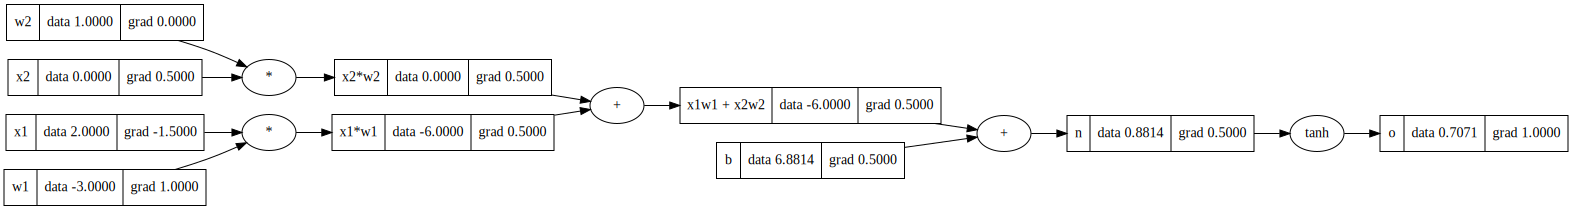

In [12]:
draw_dot(o)

In [13]:
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#----------
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----------
o.backward()

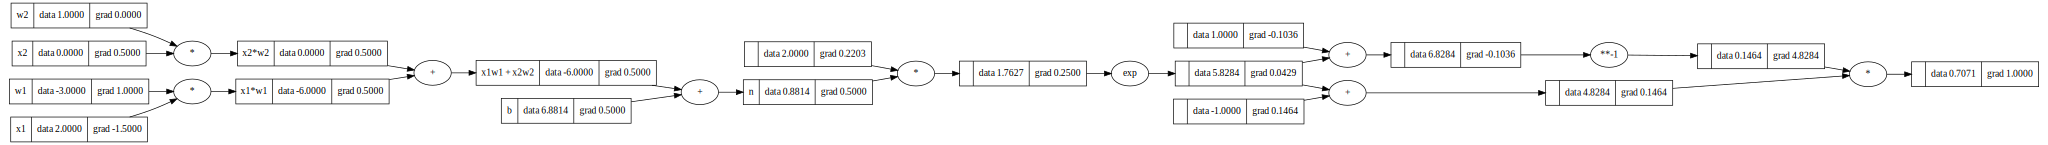

In [14]:
draw_dot(o)

In [16]:
import torch

In [19]:
x1 = torch.Tensor([2.0]).double()             ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()             ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()            ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()             ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(f'o.data.item() = {o.data.item()}')
o.backward()

print('--------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

o.data.item() = 0.7071066904050358
--------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
def lol():  # calculate gradients

  h = .0001

  a = Value(2, label='a')
  b = Value(-3, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  # add h to variables to get gradient
  a = Value(2, label='a')
  # a.data += h  # dL/da
  b = Value(-3, label='b')
  b.data += h  # dL/db
  c = Value(10, label='c')
  # c.data += h  # dL/dc
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  # d.data += h  # dL/dd
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print(f'(L2 -L1)/h = {(L2 -L1)/h}')

lol()
        

In [ ]:
_num = np.arange(-5, 5, 0.2)
plt.plot(_num, np.tanh(_num))
plt.grid

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
a = Value(3, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
a = Value(-2, label='a')
b = Value(3, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)


In [ ]:
##  backward propagation

o.grad = 1  # initialize
topo = []
visited = set()

# topological sort
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()
x2w2._backward()

In [ ]:
# topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

In [ ]:
o.grad = 1
# do/dn = 1 - tanh(n)**2 = o**2
# do/dn = 0.7071**2 = 0.5
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)